### Weight Visualization
In this notebook, code trains models in two different frameworks on MNIST data, and creates a visualization showing how the weight distributions end up being different in the two models, even with the exact same hyperparameters and dataset. 

In [16]:
!pip install palettable

     |████████████████████████████████| 111 kB 1.2 MB/s eta 0:00:01


In [119]:
import tensorflow as tf
import torch
import torchvision
import pytorch_lightning as pl
from torch import nn
import statistics
import VisualizeNN as VisNN
import matplotlib.pyplot as plt
import numpy as np

In [2]:
config = {'learning_rate': .001, 'dropout': 0.2, 'batch_size': 64, 'epochs': 25}

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(config['dropout']),
  tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

res = model.fit(x_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'])
res_test = model.evaluate(x_test, y_test)

Epoch 1/25
938/938 [==============================] - 1s 1ms/step - loss: 0.3432 - accuracy: 0.9013
Epoch 2/25
938/938 [==============================] - 1s 1ms/step - loss: 0.1655 - accuracy: 0.9515
Epoch 3/25
938/938 [==============================] - 1s 1ms/step - loss: 0.1226 - accuracy: 0.9640
Epoch 4/25
938/938 [==============================] - 1s 1ms/step - loss: 0.1003 - accuracy: 0.9694
Epoch 5/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0865 - accuracy: 0.9737
Epoch 6/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0740 - accuracy: 0.9772
Epoch 7/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0638 - accuracy: 0.9804
Epoch 8/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0586 - accuracy: 0.9814
Epoch 9/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0515 - accuracy: 0.9833
Epoch 10/25
938/938 [==============================] - 1s 1ms/step - loss: 0.0490 - accuracy: 0.9842

In [4]:
tf_model = model

In [13]:
class NumberNet(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 128), 
            nn.ReLU(), 
            nn.Dropout(config['dropout']), 
            nn.Linear(128, 10)) ### no softmax because it's included in cross entropy loss
        self.criterion = nn.CrossEntropyLoss()
        self.config = config
        self.test_loss = None
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True, 
                                                                      transform=torchvision.transforms.ToTensor(), target_transform=None, download=True), 
                                           batch_size=int(self.config['batch_size']))
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(torchvision.datasets.MNIST("~/resiliency/", train=True, 
                                                                      transform=torchvision.transforms.ToTensor(), target_transform=None, download=True), 
                                           batch_size=int(self.config['batch_size']))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        return optimizer
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        logs = {'train_loss': loss}
        return {'loss': loss}
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        logs = {'test_loss': loss}
        return {'test_loss': loss, 'logs': logs}
    
    def test_epoch_end(self, outputs):
        loss = []
        for x in outputs:
            loss.append(float(x['test_loss']))
        avg_loss = statistics.mean(loss)
        tensorboard_logs = {'test_loss': avg_loss}
        self.test_loss = avg_loss
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

In [14]:
model = NumberNet(config)
trainer = pl.Trainer(max_epochs=config['epochs'])
trainer.fit(model)
trainer.test(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     


Epoch 24: 100%|██████████| 938/938 [00:12<00:00, 77.39it/s, loss=1.475, v_num=1]

Saving latest checkpoint..


Testing:  99%|█████████▉| 929/938 [00:05<00:00, 147.51it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': 1.4718197365559496, 'test_loss': 1.4718197365559496}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 938/938 [00:05<00:00, 158.11it/s]


[{'test_loss': 1.4718197365559496, 'avg_test_loss': 1.4718197365559496}]

In [18]:
pt_model = model

### Visualize
Now that we have two trained models, perform the weight visualization of the architecture

In [30]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [33]:
pt_model

NumberNet(
  (model): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
  (criterion): CrossEntropyLoss()
)

In [ ]:
network=VisNN.DrawNN([784, 128, 128, 10, 10], tf_model.weights)
#network.draw()

In [45]:
tf_model.weights[0].numpy()[0].flatten()

array([ 0.0262569 , -0.02749777, -0.04278727, -0.04782027,  0.04502111,
       -0.0367741 , -0.04268319,  0.04609185,  0.00724438,  0.07384939,
        0.00336391, -0.07717565, -0.07593407,  0.06612589,  0.06992755,
        0.02782826,  0.04144244, -0.043245  ,  0.04122465, -0.05297097,
        0.06403949,  0.02469369, -0.0261005 , -0.06684803,  0.06408872,
        0.00384261, -0.07805467,  0.05406354, -0.05973009, -0.03668452,
        0.01757627,  0.06077703, -0.04628856, -0.05451769, -0.06439541,
       -0.01103745,  0.04991091, -0.03098516,  0.07399552,  0.02065719,
        0.02188707,  0.01644978, -0.07666518, -0.00707532,  0.03449972,
        0.04249237,  0.0768962 ,  0.05553008,  0.05328914,  0.05508768,
        0.07962012,  0.08046029,  0.00848152,  0.00225144, -0.02144289,
        0.07534172,  0.00852665,  0.03765778, -0.05368177,  0.06915311,
       -0.03401365,  0.03742402,  0.05340052, -0.01146317, -0.03126763,
       -0.02732142,  0.01946713,  0.03015736, -0.06038243,  0.01

In [47]:
from rasterio.plot import show

In [55]:
tf_model.weights[0].numpy().shape

(784, 128)

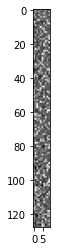

<AxesSubplot:>

In [83]:
show(tf_model.weights[2].numpy().astype(float), cmap='Greys')

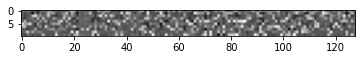

<AxesSubplot:>

In [84]:
show(list(pt_model.parameters())[2].detach().numpy(), cmap="Greys")

Text(0.5, 1.0, 'Histogram of Tensorflow Classifier Weights')

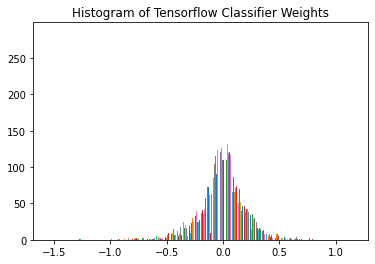

In [113]:
plt.hist(tf_model.weights[0].numpy().astype(float), bins=50, histtype="bar")
plt.title("Histogram of Tensorflow Classifier Weights")

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.7855934 , -1.733014  , -1.6804345 , -1.6278551 , -1.5752755 ,
        -1.5226961 , -1.4701166 , -1.4175372 , -1.3649577 , -1.3123783 ,
        -1.2597989 , -1.2072194 , -1.15464   , -1.1020604 , -1.049481  ,
        -0.9969016 , -0.9443221 , -0.89174265, -0.8391632 , -0.7865837 ,
        -0.73400426, -0.68142486, -0.6288454 , -0.57626593, -0.52368647,
        -0.471107  , -0.41852754, -0.36594808, -0.31336865, -0.2607892 ,
        -0.20820972, -0.15563028, -0.10305082, -0.05047136,  0.00210809,
         0.05468755,  0.107267  ,  0.15984645,  0.21242592,  0.26500538,
         0.3175848 ,  0.37016428,  0.42274374,  0.4753232 ,  0.52790266,
         0.5804821 ,  0.6330615 ,  0.685641  ,  0.73822045,  0.7907999 ,
         0.8433794 ],

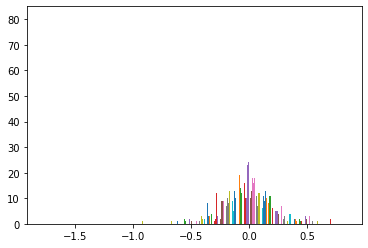

In [115]:
plt.hist(list(pt_model.parameters())[0].detach().numpy(), bins=50, histtype="bar")

In [114]:
len(tf_model.weights[0].numpy().astype(float))

784

In [116]:
len(list(pt_model.parameters())[0].detach().numpy())

128

In [121]:
len(np.array(tf_model.weights))

4

In [157]:
just_tf_weights = list()
for w in tf_model.weights:
    just_tf_weights.extend(w.numpy().flatten())

In [158]:
just_weights = np.array(just_weights)
len(just_weights)

101770

In [160]:
pt_model_weights = list(pt_model.parameters())

In [161]:
just_pt_weights = list()
for w in pt_model_weights:
    just_pt_weights.extend(w.detach().numpy().flatten())

In [162]:
len(just_pt_weights)

101770

Text(0.5, 1.0, 'Histogram of TensorFlow Classifier Weights, bin=1000')

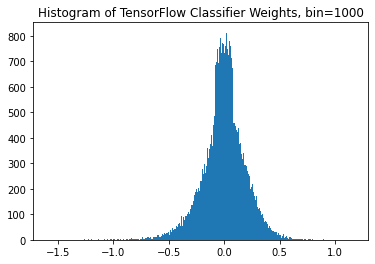

In [170]:
plt.hist(just_tf_weights, bins=1000)
plt.title("Histogram of TensorFlow Classifier Weights, bin=1000")

Text(0.5, 1.0, 'Histogram of PyTorch Classifier Weights, bin=1000')

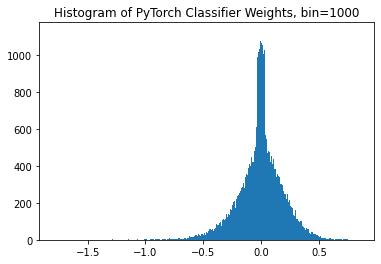

In [171]:
plt.hist(just_pt_weights, bins=1000)
plt.title("Histogram of PyTorch Classifier Weights, bin=1000")

### KL Divergence Comparison of Model Weights

In [172]:
from math import log2
 
# calculate the kl divergence
def kl_divergence(p, q):
	return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [186]:
from sklearn.preprocessing import MinMaxScaler

In [207]:
tf_weights_scaled = MinMaxScaler().fit_transform(np.array(just_tf_weights).reshape(-1, 1))+1
pt_weights_scaled = MinMaxScaler().fit_transform(np.array(just_pt_weights).reshape(-1, 1))+1

In [208]:
kl_divergence(tf_weights_scaled, pt_weights_scaled)

array([-13697.119], dtype=float32)

In [210]:
tf_weights_scaled.min()

1.0

In [211]:
kl_divergence(tf_weights_scaled, tf_weights_scaled)

array([0.], dtype=float32)

In [212]:
pt_model_2 = NumberNet(config)
trainer = pl.Trainer(max_epochs=config['epochs'])
trainer.fit(pt_model_2)
trainer.test(pt_model_2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 101 K 
1 | criterion | CrossEntropyLoss | 0     


Epoch 0:   0%|          | 2/938 [00:00<00:35, 26.17it/s, loss=2.301, v_num=2]

/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 24: 100%|██████████| 938/938 [00:09<00:00, 93.83it/s, loss=1.473, v_num=2]

Saving latest checkpoint..


Testing:   2%|▏         | 18/938 [00:00<00:05, 173.03it/s]

/Users/mzvyagin/miniconda3/envs/resiliency/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|█████████▉| 934/938 [00:06<00:00, 136.00it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_loss': 1.4713487130746659, 'test_loss': 1.4713487130746659}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 938/938 [00:06<00:00, 145.34it/s]


[{'test_loss': 1.4713487130746659, 'avg_test_loss': 1.4713487130746659}]

In [ ]:
just_pt_weights_2 = list()
for w in list(pt_model_2.parameters()):
    just_pt_weights_2.extend(w.detach().numpy().flatten())
pt_weights_2_scaled = MinMaxScaler().fit_transform(just_pt_weights_2)
kl_divergence(pt_weights_scaled, pt_weights_2_scaled)